In [1]:
import matplotlib.pyplot as plt
import torch

from torchfem import Truss
from torchfem.materials import IsotropicElasticity1D, IsotropicPlasticity1D

torch.set_default_dtype(torch.float64)

## Elastic 2D truss with linear bar elements

In [2]:
# Create material
material = IsotropicElasticity1D(1000.0)

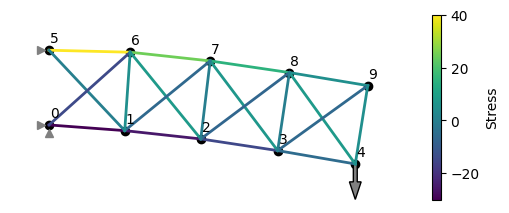

In [3]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = torch.tensor(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9],
        [1, 5],
        [0, 6],
        [2, 6],
        [1, 7],
        [3, 7],
        [2, 8],
        [4, 8],
        [3, 9],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9],
    ]
)

# Create truss
truss = Truss(nodes, elements, material)

# Set boundary conditions
truss.forces[4, 1] = -10.0
truss.constraints[0, 0] = True
truss.constraints[0, 1] = True
truss.constraints[5, 0] = True

# Solve
u, f, σ, ε, α = truss.solve()


# Plot
truss.plot(u=u, sigma=σ)

## Plastic 2D truss with linear bar elements

In [4]:
# Create material
E = 1000.0
sigma_y = 30.0
k = 500.0


# Hardening function
def sigma_f(q):
    return sigma_y + k * q


# Derivative of the hardening function
def sigma_f_prime(q):
    return k


material = IsotropicPlasticity1D(E, sigma_f, sigma_f_prime)

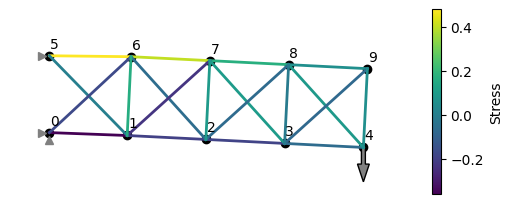

In [5]:
# Create truss
truss = Truss(nodes, elements, material)

# Set boundary conditions
truss.forces[4, 1] = -12.0
truss.constraints[0, 0] = True
truss.constraints[0, 1] = True
truss.constraints[5, 0] = True

# Solve
increments = torch.cat((torch.linspace(0.0, 1.0, 21), torch.linspace(1.0, 0.01, 21)))
u, f, σ, ε, α = truss.solve(increments=increments, return_intermediate=True)


# Plot
truss.plot(u=u[-1], sigma=σ[-1])

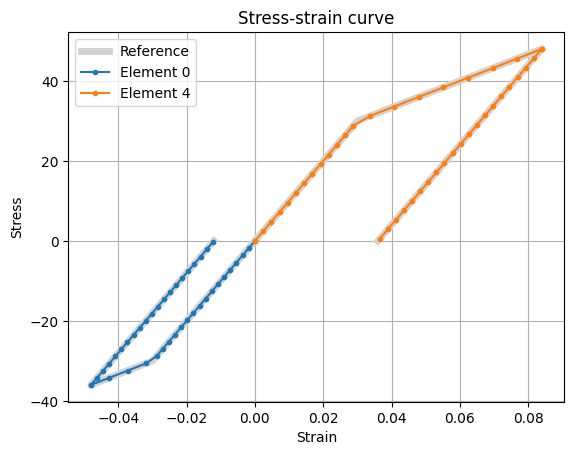

In [6]:
ε_min = min(ε[:, :, 0].min(), -sigma_y / E)
σ_min = k * E / (k + E) * (ε_min - sigma_y / k)
ε_max = max(ε[:, :, 0].max(), sigma_y / E)
σ_max = k * E / (k + E) * (ε_max + sigma_y / k)
ref_strain = [
    ε_min - σ_min / E,
    ε_min,
    -sigma_y / E,
    0.0,
    sigma_y / E,
    ε_max,
    ε_max - σ_max / E,
]
ref_stress = [0.0, σ_min, -sigma_y, 0.0, sigma_y, σ_max, 0.0]

plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")
plt.plot(ε[:, 0, 0], σ[:, 0, 0], ".-", label="Element 0")
plt.plot(ε[:, 4, 0], σ[:, 4, 0], ".-", label="Element 4")
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.title("Stress-strain curve")
plt.grid()
plt.legend()
plt.show()

## Elastic 3D truss with linear bar elements

In [7]:
# Create material
material = IsotropicElasticity1D(1000.0)

In [8]:
nodes = torch.tensor(
    [[-1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
)
elements = torch.tensor([[0, 3], [1, 3], [2, 3]])

# Create truss
truss3d = Truss(nodes, elements, material)

# Boundary conditions
truss3d.forces[3, 1] = -0.001
truss3d.constraints[0:3, :] = True

# Geometrical properties
truss3d.areas[:] = 0.05

# Solve
u, f, σ, ε, α = truss3d.solve()

# Plot
truss3d.plot(u=u, sigma=σ)

Widget(value='<iframe src="http://localhost:50645/index.html?ui=P_0x142b43b50_0&reconnect=auto" class="pyvista…